# Protein Language Models and Structure

That notebook has three parts, focusing on protein language modeling and protein structure. 
The goal is to experement with different tools and data. In particular we will be using:

- The ESM protein language model from Meta
- Multiple Sequence Alignments
- AlphaFold2/3
- Pymol

## 0. Setup

In [1]:
#these are your file inputs
# !wget -O train_esm6_data.pt https://www.dropbox.com/scl/fi/cf103vkoew0s5zys7920d/train_esm6_data.pt?rlkey=v7o2upz9txm0m284g6mgfq0ww&dl=0
# !wget -O test_esm6_data.pt https://www.dropbox.com/scl/fi/v18bvl57eog1ysjb07nww/test_esm6_data.pt?rlkey=idc0y0nzwfizxxf75kyxbfxdh&dl=0
# !wget -O train_esm150_data.pt https://www.dropbox.com/scl/fi/i4vazz4twcw38wzaykdq0/train_esm150_data.pt?rlkey=ev7tepsceqc4k5vbwsw5bsw67&dl=0
# !wget -O test_esm150_data.pt https://www.dropbox.com/scl/fi/yyjk31urec4gdwk8ajppt/test_esm150_data.pt?rlkey=v8o5mzp608w8tmxywqmn4r3ob&dl=0
# !wget -O blosum100.txt "https://drive.google.com/uc?export=download&id=1DvQJVzCEQWMm1pzaFpgl8SEPMfqIIUqY"
# !wget -O aav_alignment.a2m "https://drive.google.com/uc?export=download&id=13-1rCMccfWvcUpFESBR6ubqsKNPrBNS6"
# !wget -O aav_experiment.csv "https://drive.google.com/uc?export=download&id=1KMH8HXtKF8u7c8tHjS4S8Ht91p2neQBS"

from pathlib import Path
import matplotlib.pyplot as plt
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
import esm
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
from Bio.PDB import PDBParser, PDBList
# from google.colab import files
import os
from sklearn.decomposition import PCA
from transformers import EsmForMaskedLM, EsmTokenizer
from IPython.display import Image
from Bio.SVDSuperimposer import SVDSuperimposer

esm6_model, esm6_alphabet = esm.pretrained.esm2_t6_8M_UR50D()
esm6_model.eval()

esm150_model, esm150_alphabet = esm.pretrained.esm2_t30_150M_UR50D()
esm150_model.eval()

AA_NAME_MAP = {
  'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
  'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
  'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'TER':'*',
  'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','XAA':'X'
}

/root/miniconda3/envs/comp-biology/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Protein Language Models

Protein language models like ESM are trained using the masked language modeling objective: given an input sequence, a subset of amino acids are masked and the model is tasked with predicting the masked tokens.

This process enables the models to capture complex relationships and patterns within protein sequences, which can be leveraged in a variety of downstream applications such as predicting protein structure, function, and interactions. 

### 1.1 Amino Acid Embedding Representations

We have to understand the fundamental role of embeddings and that they are. In general, embeddings are a new representation of the tokens. In the real implementation, we should distinguish between embedding layer (first layer in NN) and train embeddings, that are final representation of input in new spaces. The embeddings from the embedding layer - are the weight matrix that learned during the training. The embeddings as a final representation - are the output of the last attention layer of NN.

In that notebook we will experiment with both types. First, we will explore the inital amino acid embeddings (from embedding layer or in other terminology from a lookup table) learned by Protein Language Models (PLMs). These embeddings are vectors from a lookup table that convert amino acid tokens into representations suitable for computational analysis. By examining these embeddings, we can understand how PLMs initially represent the biochemical properties of amino acids. We'll run a dimensionality reduction technique (ex: t-SNE) to visualize the amino acids in 2D. The hypothesis is that some amino acids may be more "similar" to each other. 

We will work with two ESM models, esm6 (esm2_t6_8M_UR50D) and esm150 (esm2_t30_150M_UR50D), both trained on Uniref50, but with 8M or 150M parameters, respectively. For more information about these models, can be check out from: https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf


In [2]:
# Create a dictionary mapping an amino acid to its vector
def get_aa_embeddings_esm(model, alphabet):
  """
  This function accesses the first embedding layer of the specified model to extract the embedding
  matrix. It then creates a dictionary mapping each amino acid token from the model's alphabet
  to its vector representation in the embedding matrix.

  Parameters:
  model (torch.nn.Module): The pretrained protein language model whose initial embedding layer
  contains the amino acid vectors.
  alphabet (esm.Alphabet): An Alphabet object that maps amino acid tokens to their indices
  within the embedding matrix.

  Returns:
  dict: A dictionary mapping amino acid tokens (str) to their corresponding embedding vectors
  (numpy.ndarray), extracted from the model's initial embedding layer.
  """
  embedding_matrix = model.embed_tokens.weight.data.numpy()
  aa_tokens = alphabet.standard_toks[:-2]
  aa_to_index = alphabet.to_dict()
  aa_to_embeddings = {aa: embedding_matrix[aa_to_index[aa]] for aa in aa_tokens}
  return aa_to_embeddings

esm6_aa_embeddings = get_aa_embeddings_esm(esm6_model, esm6_alphabet)
esm150_aa_embeddings = get_aa_embeddings_esm(esm150_model, esm150_alphabet)



In [18]:
esm6_aa_embeddings.keys()

dict_keys(['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O'])

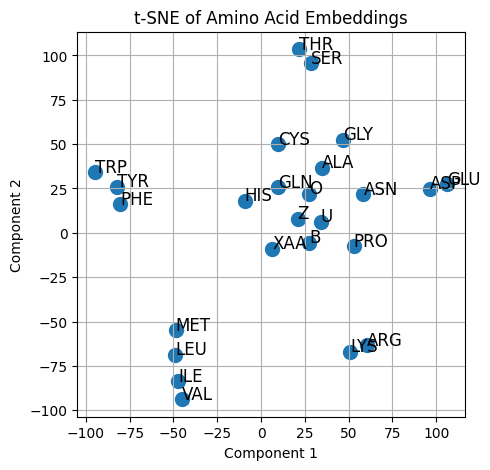

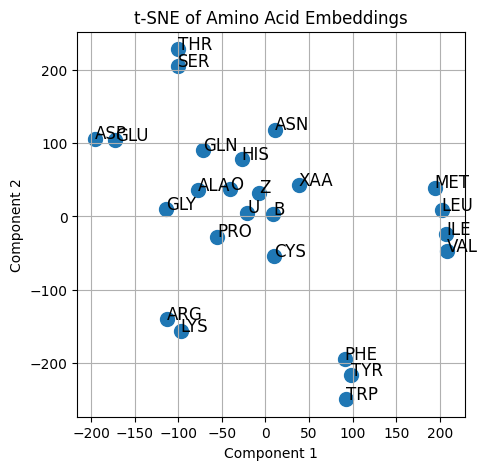

In [19]:
def plot_tsne_embeddings(embeddings, **kwargs):
    """
    Performs dimensionality reduction on the given embeddings and plots the resulting 2D layout.

    This function is designed to be flexible, allowing adjustments and additional parameters as needed for
    specific t-SNE configurations or plotting customizations. You may find matplotlib helpful.

    Returns:
    None: This function only plots the results and does not return any value.
    """
    from sklearn.manifold import TSNE
    revert_pr = {v:k for k, v in AA_NAME_MAP.items()}
    embs = np.array(list(esm6_aa_embeddings.values()))
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embs)
    plt.figure(figsize=(5, 5))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=100)
    for i, aa in enumerate(embeddings.keys()):
        plt.annotate(revert_pr.get(aa, aa), (X_embedded[i, 0], X_embedded[i, 1]), fontsize=12)
    plt.title('t-SNE of Amino Acid Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

plot_tsne_embeddings(esm6_aa_embeddings)
plot_tsne_embeddings(esm150_aa_embeddings)

Amino acids are typically grouped by physiochemical properties, and these principles are often taught in biochemistry textbooks: https://cdn.technologynetworks.com/tn/images/body/aminoacids-pic3revised1574260662291.png

Empbedings from first layer after TSNE seem to have similar clustering structure. 6 clusters can be visually separated. There are two clusters that aggregate polar amino acids (ASP, GLU vs ARG, LYS). Clusters of hydrophobic cyclic amino acids (Phe, Tyr, Trp) and acyclic amino acids (Met, Leu, Ile, Val). And more of the mixture of rest amino acids

Other common embedding techniques for amino acids are **one-hot encoding or BLOSUM encoding**. One-hot coding assumes no prior knowledge of the amino acids, representing amino acids by a vector where only one element is set to one and all other 19 amino acdis are zero. BLOck Substitution Matrix (BLOSUM) captures evolutionary substitutability. The BLOSUM amino acids embedding for a given amino acid is also length 20 (the row of values that represents its substitutability with each of  amino acids). We apply the same dimensional reduction strategy to now visualize the BLOSUM100 embeddings in 2D.

/tmp/ipykernel_20637/3510168678.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  embedding_matrix = pd.read_csv("blosum100.txt",delim_whitespace=True,header=0)


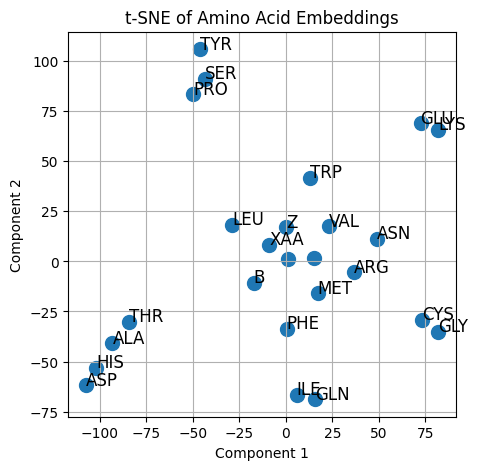

In [24]:
# Create a dictionary mapping an amino acid to its vector
def get_aa_embeddings_blosum():
  """
  Reads a BLOSUM100 matrix from a text file and converts it into a dictionary mapping each
  amino acid to its corresponding vector representation.

  Returns:
  dict: A dictionary where keys are amino acid characters (str) and values are their
        associated vector representations (numpy.ndarray) derived from the BLOSUM100 matrix.
  """
  embedding_matrix = pd.read_csv("blosum100.txt",delim_whitespace=True,header=0)
  aa_to_embeddings = {aa: embedding_matrix.values[index] for index, aa in enumerate(embedding_matrix.index)}
  return aa_to_embeddings

blosum_embedding = get_aa_embeddings_blosum()

plot_tsne_embeddings(blosum_embedding)

It is much different for BLOSUM embedings. The clusters seem to aggregate more on structural features like geomentrical structure, length then on similarity in their chemical properties.

### 1.2 Sequence-level embeddings

Now, we will explore sequence-level embeddings and apply them to build a simple classifier. Sequence-level embeddings pool all tokens in a sequence into one vector. We can obtain them by sending entire protein sequence into the model, taking last hidden state and pooling over all tokens. 

Our goal is to predict the sub-cellular localization of proteins, focusing specifically on identifying whether a protein is a membrane protein.

Membrane proteins are integral to the cell's interactions with its environment and internal communications. They are embedded within the cellular membranes, including the plasma membrane that encloses the cell and the membranes of various organelles such as the mitochondria and endoplasmic reticulum. Membrane proteins play roles in various cellular processes including signal transduction, transport of molecules, and cell-cell recognition.

We will train a simple classifier - a logistic regression model using sklearn with settings C=10 and max_iter=1000:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html



Train and test data is provided for both ESM6 and ESM150 models. We will train one classifier on each model and compare model performance on the test sets. Note that these two datasets are the same, but the sequence embedding vector depends on the esm model.

In [33]:
# Loading the Dataset
# The datasets loaded below consist of lists of 2-tuples, each containing:
# 1. A learned representation (often referred to as an "embedding") of a protein sequence.
# 2. A boolean label (True/False) indicating whether the protein is a membrane protein.
train_esm6 = torch.load(Path.cwd() / "models/train_esm6_data.pt", weights_only=False)
test_esm6 = torch.load(Path.cwd() / "models/test_esm6_data.pt", weights_only=False)

train_esm150 = torch.load(Path.cwd() / "models/train_esm150_data.pt", weights_only=False)
test_esm150 = torch.load(Path.cwd() / "models/test_esm150_data.pt", weights_only=False)

In [49]:
len(test_esm150), len(test_esm150[0]), type(test_esm150[0][0][0])

(1619, 2, numpy.float32)

In [47]:
pd.DataFrame([i[0] for i in test_esm6]).describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1619.0,-0.010760,0.098425,-0.426234,-0.072068,-0.010905,0.050364,0.405218
std,0.0,0.279480,0.032062,0.320269,0.298941,0.288211,0.269863,0.170716
min,1619.0,-4.611530,0.062396,-5.309928,-5.018844,-4.767630,-4.365999,-1.333052
25%,1619.0,-0.059062,0.084687,-0.493854,-0.117548,-0.059719,-0.000068,0.300311
50%,1619.0,0.006520,0.093645,-0.391097,-0.057273,0.003409,0.066686,0.391095
75%,1619.0,0.069731,0.105968,-0.308333,0.007777,0.072927,0.129530,0.500485
max,1619.0,0.289755,0.537014,-0.104234,0.188917,0.320198,0.434748,0.929694


Next, initialize and train the classifier on your training dataset. Here, we'll set up the logistic regression classifier using the given parameters: C=10 and max_iter=1000.

In [50]:
def train_membrane_classifier(train_data, **kwargs):
    """
    Trains a classifier on protein sequence embeddings to predict membrane protein status.

    This function initializes and fits a model (which can be logistic regression, though alternatives
    are allowed) using the provided training data. The classifier is trained to distinguish between
    membrane and non-membrane proteins based on their learned embeddings, such as ESM-6 or ESM-150.

    Parameters:
    - train_data (list of tuples): A list where each element is a tuple containing:
        1. An embedding vector (np.ndarray) representing a protein sequence.
        2. A boolean label (True/False) indicating whether the protein is a membrane protein.

    Returns:
    - model: The trained (logistic regression or other) model. It should take in a tensor/matrix
      representation and return logits or probabilities of being a membrane protein or not.
    """
    from sklearn.linear_model import LogisticRegression

    # Extracting features and labels from the training data
    X, y = zip(*train_data)
    # Convert the list of embeddings to a numpy array
    X = np.array(X)
    y = np.array(y)

    # Initialize a logistic regression model with standard scaling
    model = LogisticRegression(max_iter=1000, C=10, **kwargs)

    # Fit the model to the training data
    model.fit(X, y)

    return model

model_on_esm6 = train_membrane_classifier(train_esm6)
model_on_esm150 = train_membrane_classifier(train_esm150)

Now that the classifiers are trained, we can make predictions and evaluate each model on their test set using accuracy and ROC-AUC (from sklearn.metrics: https://scikit-learn.org/1.5/api/sklearn.metrics.html).

In [51]:
def evaluate_model_performance(model, test_data):
    """
    Uses the provided trained model to make predictions on the test dataset,
    and then computes two performance metrics: accuracy and ROC-AUC score. Accuracy measures
    the proportion of correct predictions (both true positives and true negatives) while
    ROC-AUC score provides an aggregate measure of performance across all possible
    classification thresholds, focusing on the model's ability to distinguish between classes.

    Parameters:
    - model: The trained model, which should have a predict method for generating predictions
             and a predict_proba method for generating class probabilities.
    - test_data (list of tuples): A list where each element is a tuple containing:
        1. An embedding vector (np.ndarray) representing a protein sequence.
        2. A boolean label (True/False) indicating whether the protein is a membrane protein.

    Returns:
    - accuracy (float): The fraction of correctly classified samples.
    - roc_auc (float): The ROC-AUC score indicating the model's ability to discriminate between
                       the classes.

    """
    from sklearn.metrics import accuracy_score, roc_auc_score
    # Extracting features and labels from the test data
    X_test, y_test = zip(*test_data)
    # Convert the list of embeddings to a numpy array
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    # Making predictions using the model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculating ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    return accuracy, roc_auc


# Evaluate the model on ESM6
accuracy_ESM6, roc_auc_ESM6 = evaluate_model_performance(model_on_esm6, test_esm6)
# Evaluate the model on ESM150
accuracy_ESM150, roc_auc_ESM150 = evaluate_model_performance(model_on_esm150, test_esm150)
print(f"Evaluating model performance...")
print(f"Accuracy ESM6: {accuracy_ESM6:.4f}")
print(f"ROC-AUC ESM6: {roc_auc_ESM6:.4f}")
print(f"Accuracy ESM150: {accuracy_ESM150:.4f}")
print(f"ROC-AUC ESM150: {roc_auc_ESM150:.4f}")

Evaluating model performance...
Accuracy ESM6: 0.9259
ROC-AUC ESM6: 0.9381
Accuracy ESM150: 0.9333
ROC-AUC ESM150: 0.9549


ESM150 performs better in that task. It's expected, since it is more complex model with bigger set of parameters.

### 1.3 Mutation effect prediction

In that chapter we will explore another application of protein language model. That time this is about the mutation effect. Sometimes we want to introduce some mutation in a protein to adjust properties (ex. enzymatic activity, binding affinity, stability, etc), or we want track the effect of mutation, how mutation affect the fitness. Often we want perform **Deep Mutation Scanning** (high-throughput experiment) where we make a large library of variants of a protein (single amino acid substitutions ao double/triple mutations), then we measure a property of interest (fitness) and compare by some score (**DMS**). With DMS score > 0 -> variant is better, with DMS score < 0 -> variant is worse.

In biology, a mutation refers to any change in the DNA sequence that can alter the amino acid sequence of a protein. Proteins, encoded by genes, perform essential functions in living organisms, and any change in their structure due to mutations can impact their function.

**Wild-Type Proteins**: This term refers to the most common form of a protein found in a population, serving as the standard version for comparison in genetic studies. In contrast, a **mutant** protein has a different sequence from the wild-type.

**Gain of function mutations** introduce new or enhanced activities in a protein.
**Loss of function mutations** reduce or eliminate the ability of the protein to perform its normal functions.

A goal is to predict how specific mutations in the protein sequence affect its function. This prediction helps in understanding how genetic variations contribute to different traits, diseases, or responses to drugs, much like predicting how changes in a software's code would affect its operation.

We use the ESM model to perform mutation effect prediction. We will compare our prediction to an experimental deep mutational scan (DMS), where most single amino acid mutations (and some combinations of mutations) are made to the Adeno-associated virus
(AAV) capsid protein and the fitness impact of each mutation is measured. Here, the fitness is the ability of the capsid to assemble and package (viability). Higher scores are more fit or gain of function, and lower scores have less fitness or loss of function.


#### Masked marginal scoring function

Since protein language model was train with masking approach, when we mask some amino-acid in a sequence and allow model to predict the logit for every possible amino-acid, we can use logits predictions directly. If we know what particular amino-acid was mutation to what conterpair, we can compare logits for wild and mutated amino-acid by log-odd score with DMS score, the score obtained from the direct measure form Deep Mutation Scanning.

Terminology here:

Soft-max: $$p_i = \frac{\exp{l_i}}{\sum_{i=1}^n \exp{l_i}} $$
Masked marginal scoring function: $$\sum_{i} \log{p(x_i = x_i^{mt} | x_M)} - \log{p(x_i = x_i^{wt} | x_M)} $$
Here, M are the masked residues where mutations occur, $x^{mt}_i$ is the mutant-type residue at position i and $x^{wt}_i$ is the wild-type residue at position i. We will just consider single mutations at a time.

The idea here is the model will asign higher probability to more fit protein (the one that will show high survivence during the selection) and lower probability to the one, that rarely occuired in nature.

Code predicts mutation effects using the ESM 8M model (from Hugging Face: https://huggingface.co/facebook/esm2_t6_8M_UR50D).

In [20]:
def load_esm_model():
    """
    Loads the ESM2 model and tokenizer from Hugging Face and moves the model to GPU if available.

    This function initializes the "facebook/esm2_t6_8M_UR50D" model (designed for protein language
    modeling) and its tokenizer, then checks if a CUDA-compatible GPU is available. If so, it sends
    the model to the GPU to speed up computations; otherwise, it sticks with the CPU.

    Returns:
    - model: The ESM2 model ready for protein sequence tasks.
    - tokenizer: The tokenizer that processes protein sequences for the model.
    """
    model_name = "facebook/esm2_t6_8M_UR50D"
    model = EsmForMaskedLM.from_pretrained(model_name)
    tokenizer = EsmTokenizer.from_pretrained(model_name)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    return model, tokenizer

model, tokenizer = load_esm_model()

In [ ]:
def seq_to_esm_logits(sequence, mutation, model, tokenizer):
    """
    Computes the logits for a masked position in a protein sequence where a mutation is specified.

    This function modifies a given protein sequence by masking the amino acid at the position specified
    by the mutation. It then tokenizes this sequence using a pre-trained tokenizer and passes it to a
    pre-trained model to predict the logits (unnormalized log probabilities) for all possible amino acids
    at the masked position.

    Parameters:
    - sequence (str): The original protein sequence.
    - mutation (str): A string indicating the position and the new amino acid, e.g., 'A234B'.
                      The mutation format should be: original amino acid, position (1-based index), new amino acid.

    Returns:
    - logits (torch.Tensor): A tensor of shape (1, number of possible amino acids) containing the logits for
                             each amino acid at the masked position.

    Note:
    - The position in the mutation string is assumed to be 1-based, and Hugging Face tokenizer uses zero-indexing.
      The function automatically adjusts for this indexing difference.
    """
    pos = int(mutation[1:-1])
    # Convert sequence to a list to perform mutations
    sequence_list = list(sequence)

    # Mask the position where the mutation is to be applied
    sequence_list[pos - 1] = tokenizer.mask_token  # Using position-1 because Hugging Face uses zero-indexing
    masked_sequence = "".join(sequence_list)

    # Tokenize the sequence with the masked token
    inputs = tokenizer(masked_sequence, return_tensors="pt")

    # Move inputs to the same device as the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ##copy device code from above if needed
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict the masked token probabilities
    with torch.no_grad():
        output = model(**inputs)

    # Get the logits for the masked token at the mutated position
    # this should be equivalent to pos - 1 here, but it is more flexible
    masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    logits = output.logits[0, masked_index, :]
    return logits

In [23]:
sequence = "MYSEQUENCE"
mutation = "Y2A"
logits = seq_to_esm_logits(sequence, mutation, model, tokenizer)

Full function to score a mutation to a given sequence.

In [24]:
def score_mutant_masked_marginal(sequence, mutation, model, tokenizer):
    """
    Calculates the effect of a mutation in a protein sequence using the masked marginal probability method.

    This function determines the effect of substituting one amino acid for another at a specific position
    in a protein sequence. It computes the logits for all possible amino acids at the mutated position
    using a pre-trained model. The function then converts these logits into probabilities and compares
    the probability of the original amino acid with that of the mutated amino acid to estimate the
    mutation's impact.

    Parameters:
    - sequence (str): The original protein sequence.
    - mutation (str): A string specifying the mutation, formatted as 'XnY', where 'X' is the original amino acid,
                      'n' is the position (1-based index), and 'Y' is the new amino acid.

    Returns:
    - mutation_effect (float): The log-ratio of the probabilities of the mutated amino acid to the original amino acid,
                               providing a measure of how the mutation affects the protein's fitness.

    The function outputs a positive value for a gain of function (mutant more likely than wild type) and a negative
    value for a loss of function (mutant less likely than wild type).
    """
    original_aa = mutation[0]
    pos = int(mutation[1:-1])
    mutated_aa = mutation[-1]

    logits = seq_to_esm_logits(sequence, mutation, model, tokenizer) ##CHANGED THIS LINE TO ADD MODEL
    # print(f"Shape of logits: {logits.shape}")  #comment this out during the for loop

    ### COMPLETE HERE
    # Convert original and mutated amino acids to their token IDs
    original_aa_id = tokenizer.convert_tokens_to_ids(original_aa)
    mutated_aa_id = tokenizer.convert_tokens_to_ids(mutated_aa)

    # Get the softmax probabilities from the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    #Select probabilities (taken from logits) of original and mutated amino acids using their token ids ()
    original_prob = probabilities[0, original_aa_id]
    mutated_prob = probabilities[0, mutated_aa_id]

    # Compute the mutation effect: log-ratio of the probabilities
    mutation_effect = math.log(mutated_prob / original_prob) if original_prob > 0 else float('inf')

    return mutation_effect

score_mutant_masked_marginal(sequence, mutation, model, tokenizer)

0.7600752036404227

The AAV file provides the experimental data in the AAV deep mutational scan. Our goal will be to compare the score made by ESM2 versus the experimental scores.

In [25]:
def compute_esm_scores_for_mutations(experiment_data, background_sequence, model, tokenizer):
    """
    Computes ESM scores for each single mutation in the experimental data using a given background sequence.

    This function filters the experimental data to focus only on single mutations, computes ESM scores for each mutation,
    and appends these scores to the dataframe.

    Parameters:
    - experiment_data (pandas.DataFrame): The experimental data containing a column 'mutant' with mutation strings.
    - background_sequence (str): The background protein sequence used as the basis for mutation.

    Returns:
    - experiment_data (pandas.DataFrame): The modified DataFrame with an additional column 'esm_score' containing
                                          the computed ESM scores for each mutation.

    Usage:
    This function is specifically designed to handle data formats where mutations are denoted as single string entries
    in the 'mutant' column of the provided DataFrame. It requires the background sequence of the protein to be fully
    specified and expects that the sequence and mutations correspond accurately to each other.
    """
    # Filter for single mutations
    experiment_data["num_muts"] = experiment_data['mutant'].str.split(":").str.len()
    experiment_single_muts = experiment_data[experiment_data['num_muts'] == 1]

    # List of all single mutations
    aav_mutations = experiment_single_muts['mutant'].values

    # Compute ESM scores for each mutation
    esm_scores = [score_mutant_masked_marginal(background_sequence, mutation, model, tokenizer) for mutation in aav_mutations]

    # Append ESM scores to the DataFrame
    experiment_single_muts['esm_score'] = esm_scores

    return experiment_single_muts

# Load experimental data
experiment = pd.read_csv("aav_experiment.csv")

# Wild type AAV sequence used in experiment
aav_sequence = "MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLVLPGYKYLGPFNGLDKGEPVNEADAAALEHDKAYDRQLDSGDNPYLKYNHADAEFQERLKEDTSFGGNLGRAVFQAKKRVLEPLGLVEEPVKTAPGKKRPVEHSPVEPDSSSGTGKAGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGSGAPMADNNEGADGVGNSSGNWHCDSTWMGDRVITTSTRTWALPTYNNHLYKQISSQSGASNDNHYFGYSTPWGYFDFNRFHCHFSPRDWQRLINNNWGFRPKRLNFKLFNIQVKEVTQNDGTTTIANNLTSTVQVFTDSEYQLPYVLGSAHQGCLPPFPADVFMVPQYGYLTLNNGSQAVGRSSFYCLEYFPSQMLRTGNNFTFSYTFEDVPFHSSYAHSQSLDRLMNPLIDQYLYYLSRTNTPSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVLIFGKQGSEKTNVDIEKVMITDEEEIRTTNPVATEQYGSVSTNLQRGNRQAATADVNTQGVLPGMVWQDRDVYLQGPIWAKIPHTDGHFHPSPLMGGFGLKHPPPQILIKNTPVPANPSTTFSAAKFASFITQYSTGQVSVEIEWELQKENSKRWNPEIQYTSNYNKSVNVDFTVDTNGVYSEPRPIGTRYLTRNL"

# Compute ESM scores
experiment_scores = compute_esm_scores_for_mutations(experiment, aav_sequence, model, tokenizer)

/tmp/ipykernel_1088/977630920.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_single_muts['esm_score'] = esm_scores


In [26]:
experiment

,mutant,mutated_sequence,DMS_score,DMS_score_bin,num_muts
0,A572C,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.783106,1,1
1,A572C:E574A,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-1.910004,0,2
2,A572C:E574A:Q584C:R585V,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.135085,0,4
3,A572C:E574A:S578V:Q584C:R585P,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.901771,0,5
4,A572C:E574A:T581S:N582G,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-2.227975,0,4
...,...,...,...,...,...
42323,Y576W:V579Y:S580D:L583D:Q584E,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.424268,1,5
42324,Y576W:V579Y:S580D:N587D,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,1.175576,1,4
42325,Y576W:V579Y:T581D:R585V:N587D,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.847795,1,5
42326,Y576W:V579Y:T581E:N582I:L583E:R588A,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.751041,1,6


Spearman correlation: 0.20, Pearson correlation: 0.15


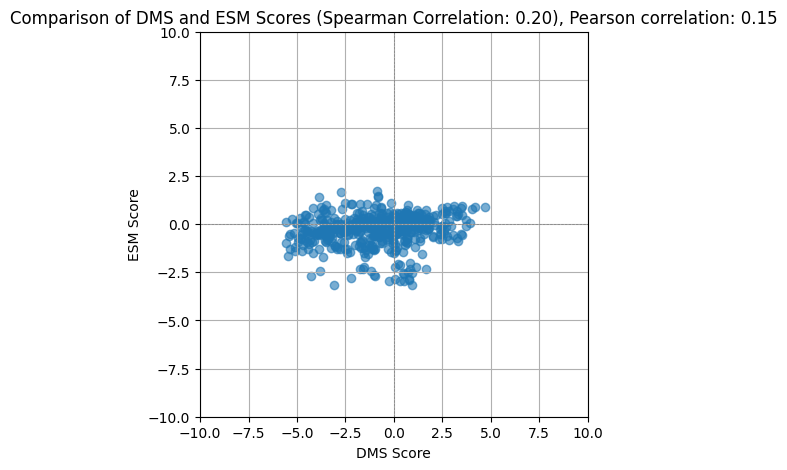

(np.float64(0.14727308647183102), np.float64(0.2029648803217699))

In [27]:
def compare_scores(experiment_scores):
    """
    Generates a scatter plot to compare experimental DMS scores with model ESM scores and calculates
    the Spearman correlation between them.

    Parameters:
    - experiment_scores (pandas.DataFrame): DataFrame with columns 'DMS_score' for experimental scores and
      'esm_score' for model scores.

    Returns:
    - float: The Spearman correlation coefficient indicating the relationship between the two score sets.
    """
    corr_prs = experiment_scores['DMS_score'].corr(experiment_scores['esm_score'], method='pearson')
    corr_sp = experiment_scores['DMS_score'].corr(experiment_scores['esm_score'], method='spearman')
    print(f"Spearman correlation: {corr_sp:.2f}, Pearson correlation: {corr_prs:.2f}")
    plt.figure(figsize=(5, 5))
    plt.scatter(experiment_scores['DMS_score'], experiment_scores['esm_score'], alpha=0.6)
    plt.title(f"Comparison of DMS and ESM Scores (Spearman Correlation: {corr_sp:.2f}), Pearson correlation: {corr_prs:.2f}")
    plt.xlabel("DMS Score")
    plt.ylabel("ESM Score")
    plt.grid(True)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.show()
    return corr_prs, corr_sp

compare_scores(experiment_scores)

The correlation is not very high, less than expected. Potential causes for that can lie in several factors:
 * We used single mutations. Obviously, most of mutations should not be considered in isolation and are ofter paired with other mutation in the same active site. 
 * We have a much narrow distribution in ESM score than in DMS score. Since the ESM score is calculated as a log-likelihood difference - equivalent to the difference in logits - we can assume that the model assign similar score to both mutant and wild types. Possible reason - most residues changed significantly over evolution and probably doesn't carry function. Probably we should identify those mutations that are on the tails of the distribution, and annotate only them. 

#### Position Site Score

We will compare observation from the previous chapter with ones obtained from sequence alignment. Position Site Score Matrix (PSSM), we used in the previous notebook, will be our set of truth. We will calculate how often every amino-acid is found at Mutation position and use it to calculate similar scoring function: $\log {\frac{p(x^{mt})}{p(x^{wt})}}$

Let's generate a multiple sequence alignment (MSA) for AAV. In a multiple sequence alignment, homologous residues among a set of sequences are aligned together in columns. MSAs are used for traditional method to learn mutation effects by analyzing the probability of different mutations in the set of homologous or evolutionary-related sequences.







Let's compute an Position Site Score Matrix (PSSM) from either the provided alignment. A PSSM is the frequency (probability) of each amino acid at each position in the alignment. Amino acids that aren't in the alignment at that position are given low (negative) scores. 

Remark: we have to consider the corner case when no alignments occuired for some amino-acids. We will remove them from final scores

In [29]:
from Bio.motifs import Motif

In [30]:
def generate_pssm_and_update_experiment(msa_file, experiment_data, **kwargs):
    """
    This function processes an MSA to compute the frequency of each amino acid at each position in the alignment,
    ignoring non-amino acid characters. It then computes a score for each mutation in the experimental data based
    on the PSSM and updates the DataFrame with these scores.

    Notes: 1) Load the Multiple Sequence Alignment (MSA) file (aav_alignment.a2m).
    2) Ignore characters "-" and "X" (or others if needed that aren't amino acids)
    3) Add mutation effect PSSM scores into the experimental data frame for all mutations in the AAV experiment
    4) Can use Biopython or calculate frequencies yourself (in biopython, you can use the "fasta" type for this "a2m" alignment)

    Parameters:
    - msa_file (str): Path to the file containing the MSA data, typically in .a2m or similar format.
    - experiment_data (pandas.DataFrame): DataFrame containing experimental data with a column for mutations.

    Returns:
    - pandas.DataFrame: Updated DataFrame including a new column with PSSM scores for each mutation.
    """
    # Load the MSA file
    alignment = AlignIO.read(msa_file, "fasta")
    # Create a position-specific scoring matrix (PSSM)
    aa = "".join(set(AA_NAME_MAP.values())-set(['X', '*']))  # Exclude 'X' and '-' from the amino acids
    aa_matrix = Motif(aa, alignment.alignment).counts
    # Convert the PSSM to a DataFrame for easier manipulation
    pssm_df = pd.DataFrame(list(aa_matrix.values()), index=aa_matrix.keys(), columns=list(range(1, alignment.get_alignment_length() + 1)))
    pssm_df = pssm_df.T[pssm_df.sum(axis=0) > 0].T
    # Normalize the PSSM to get frequencies
    pssm_df = pssm_df.div(pssm_df.sum(axis=0), axis=1)
    # Initialize a new column for PSSM scores in the experiment DataFrame
    experiment_data['pssm_score'] = 0.0
    # Iterate through each mutation in the experimental data
    for index, row in experiment_data.iterrows():
        mutation = row['mutant']
        if mutation:  # Ensure mutation is not empty
            original_aa = mutation[0]  # First character is the original amino acid
            pos = int(mutation[1:-1])  # Middle part is the position (1-based index)
            mutated_aa = mutation[-1]  # Last character is the mutated amino acid
            
            # Get the PSSM score for the mutated amino acid at the specified position
            if pos in pssm_df.columns and pssm_df.loc[original_aa, pos] > 0 and pssm_df.loc[mutated_aa, pos] > 0:
                pssm_score = math.log2(pssm_df.loc[mutated_aa, pos] / pssm_df.loc[original_aa, pos])
                experiment_data.at[index, 'pssm_score'] = pssm_score
            else:
                print(f"Warning: Mutation {mutation} at position {pos} with amino acid {mutated_aa} not found in PSSM.")
    # Return the updated DataFrame with PSSM scores
    return experiment_data


result = generate_pssm_and_update_experiment("aav_alignment.a2m", experiment_scores)

/tmp/ipykernel_1088/1551297572.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_data['pssm_score'] = 0.0


In [31]:
result

,mutant,mutated_sequence,DMS_score,DMS_score_bin,num_muts,esm_score,pssm_score
0,A572C,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.783106,1,1,-2.819940,0.000000
219,A572D,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-0.932205,1,1,-0.403634,-4.958421
248,A572E,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-3.875080,0,1,-0.462956,-8.417853
265,A572F,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-3.486448,0,1,-0.314972,0.000000
282,A572G,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.166455,1,1,0.050629,-0.656301
...,...,...,...,...,...,...,...
42024,Y576R,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.147604,0,1,0.857737,0.000000
42037,Y576S,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-0.878502,1,1,1.739657,-6.392317
42053,Y576T,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-2.714789,0,1,1.660241,-8.977280
42073,Y576V,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-2.211178,0,1,1.057343,-8.977280


**The correlation between the model scores (PSSM) and the experiments (DMS_score)**

Spearman correlation: 0.42, Pearson correlation: 0.41


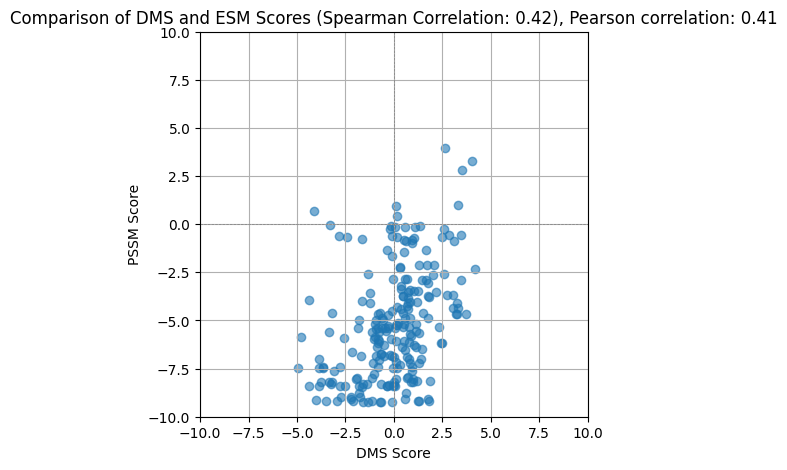

(np.float64(0.40807248667060214), np.float64(0.4188461089668052))

In [32]:
def compare_dms_pssm_scores(experiment_scores, **kwargs):
    """
    Create scatterplot comparing single mutation experiment dms scores and model PSSM scores.
    Calculate spearman between experiment dms scores and model PSSM scores

    Parameters:
    - experiment_scores (pandas.DataFrame): DataFrame containing 'DMS_score' for experimental scores
      and 'pssm_score' for model predictions.

    Returns:
    - float: Spearman correlation coefficient, quantifying the degree to which the model predictions
      are associated with the experimental results.
    """
    experiment_scores_tmp = experiment_scores[experiment_scores['pssm_score'].ne(0)]
    corr_prs = experiment_scores_tmp['DMS_score'].corr(experiment_scores_tmp['pssm_score'], method='pearson')
    corr_sp = experiment_scores_tmp['DMS_score'].corr(experiment_scores_tmp['pssm_score'], method='spearman')
    print(f"Spearman correlation: {corr_sp:.2f}, Pearson correlation: {corr_prs:.2f}")
    plt.figure(figsize=(5, 5))
    plt.scatter(experiment_scores_tmp['DMS_score'], experiment_scores_tmp['pssm_score'], alpha=0.6)
    plt.title(f"Comparison of DMS and ESM Scores (Spearman Correlation: {corr_sp:.2f}), Pearson correlation: {corr_prs:.2f}")
    plt.xlabel("DMS Score")
    plt.ylabel("PSSM Score")
    plt.grid(True)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.show()
    return corr_prs, corr_sp

compare_dms_pssm_scores(result)

We made additional step by eliminating those mutation, that don't have counts in gomologs. That significantly approved the correlation value, that now is 0.42, showing that having only real variance in homologs mutations correlates well with results from DMS assay.


## 2. Structure Prediction

In this part, we will predict the structure of the AAV protein using both AlphaFold2 and AlphaFold3.


1. We will run prediction using AlphaFold2 and AlphaFold3.
    For AlphaFold2 we will use the notebook: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb
    For AlphaFold3 - https://alphafoldserver.com/about
2. We will compare predictions by aligning them first with SVD and calculating error of predictions as RMSD.
3. Display the contact map for two predictions


In [ ]:
def load_pdb_file(file_name):
  """
  Load a PDB file and extract the structure, amino acid sequence, and coordinates of the alpha carbons.

  This function only processes the first model and the chain with ID 'A' from the PDB file.

  Parameters:
  file_name (str): The path to the PDB file to be loaded.

  Returns:
  tuple:
      - Bio.PDB.Structure.Structure: The complete structure as parsed from the file.
      - str: The sequence of amino acids from chain A.
      - numpy.ndarray: The coordinates of the alpha carbons in chain A.
    """
  pdbp = PDBParser()
  struct = pdbp.get_structure("struct", file_name)
  model = struct[0]

  sequence = []
  coords = []
  for chain in model:
    if chain.id != "A":
      continue
    for residue in chain:
      coords.append(residue['CA'].get_vector().get_array())
      resname = AA_NAME_MAP[residue.resname]
      sequence.append(residue.resname)

  return struct, "".join(sequence), np.array(coords)

def display_image(file_name):
  """
  Parameters:
  file_name (str): The path to the image file to be displayed.

  Returns:
  IPython.core.display.Image: An image object that can be displayed in an IPython notebook.
  """
  return Image(filename=file_name)

af2_coords = load_pdb_file(Path.cwd() / "models/alphafold/test_3254c/test_3254c_unrelaxed_rank_005_alphafold2_ptm_model_2_seed_000.pdb")

**AlphaFold2**

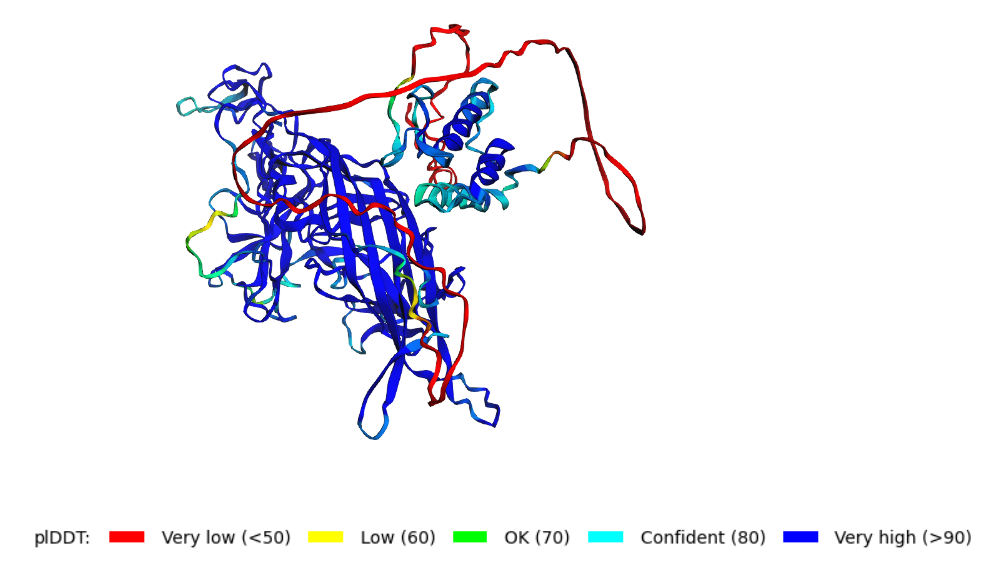

In [3]:
display_image(Path.cwd() / "models/alphafold/Screenshot 2025-08-13 215431.png")

**AlphaFold3**

In [7]:
from Bio.PDB import PDBParser, PDBIO, MMCIFParser

# Create a parser for CIF files
parser = MMCIFParser() 

# Parse the CIF file
structure = parser.get_structure('my_structure', Path.cwd() / "models/alphafold/alphafold3/fold_2025_08_13_22_11_model_4.cif")

# Create a PDB writer
io = PDBIO()

# Set the structure to be written
io.set_structure(structure)

# Write the structure to a PDB file
io.save(str(Path.cwd() / "models/alphafold/alphafold3/fold_2025_08_13_22_11_model_4.pdb"))
af3_coords = load_pdb_file(Path.cwd() / "models/alphafold/alphafold3/fold_2025_08_13_22_11_model_4.pdb")

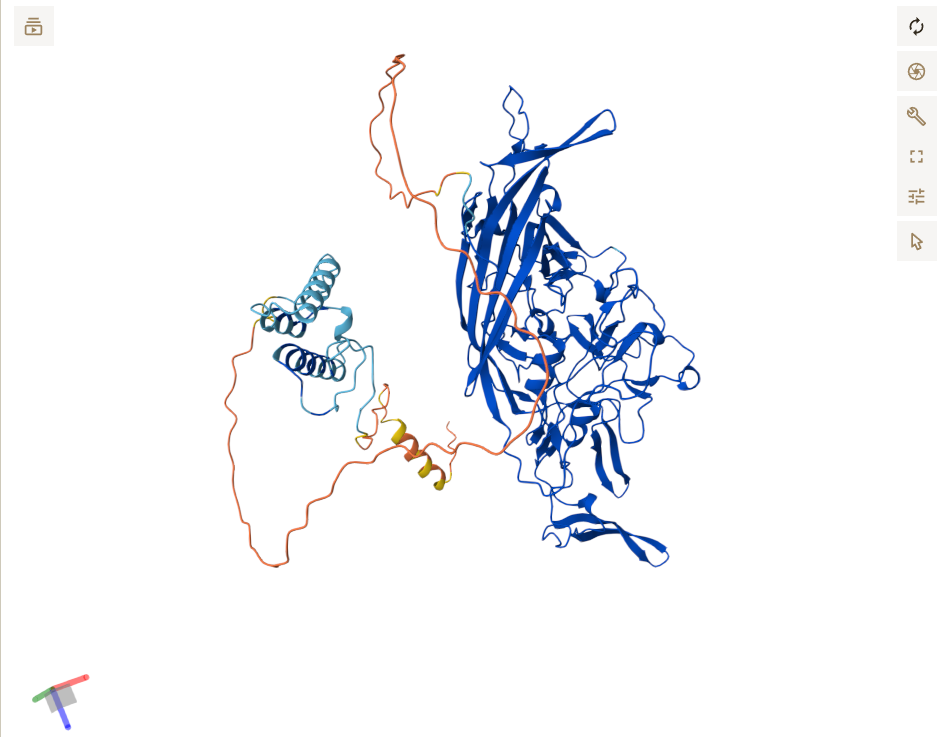

In [9]:
display_image(Path.cwd() / "models/alphafold/Screenshot 2025-08-13 222702.png")

#### 2.1 Compare predictions

Now we will compare the two predictions. For this, you will compute the RMSD. Recall the RMSD:

$$ f(x, y) = \frac{1}{N} \sum_{i=1}^N ||x_i - y_i||^2  \\
RMSD(x, y) = \sqrt{f(x, y)} $$


First we will align the two structures and then we will compute the deviation.

In [12]:
def compute_rmsd(coords1, coords2):
    """
    Calculate the root-mean-square deviation (RMSD) after optimal superposition.

    This function aligns the second set of coordinates onto the first using the
    Singular Value Decomposition (SVD) method provided by the SVDSuperimposer class,
    and computes the RMSD between them.

    Parameters:
    coords1 (numpy.ndarray): The reference coordinate set as a NxD numpy array,
                             where N is the number of points and D is the dimensionality.
    coords2 (numpy.ndarray): The coordinate set to align as a NxD numpy array,
                             matching the dimensions of coords1.

    Returns:
    float: The computed RMSD value indicating the average distance between all pairs
           of corresponding points after optimal superposition.
    """
    sup = SVDSuperimposer()
    sup.set(coords1, coords2)
    sup.run()
    rms = sup.get_rms()
    trans_coord = sup.get_transformed()
    ref_coord = sup.reference_coords
    return rms, trans_coord, ref_coord

score, tr_coord, ref_coord = compute_rmsd(af2_coords[2], af3_coords[2])
print(f"RMSD: {score:.3f} Angstroms")
# print(compute_rmsd(af2_coords[2], af3_coords[2]))

RMSD: 16.830 Angstroms


In [15]:
np.max(tr_coord, axis=0) - np.min(tr_coord, axis=0), np.max(ref_coord, axis=0) - np.min(ref_coord, axis=0)

(array([ 97.69263304, 103.6879981 , 113.53561817]),
 array([ 94.96900177,  97.93800354, 129.375     ]))

Considering dimensions of predicted proteins to be 100 Angstroms in any of 3D directions, difference in 17 Angstroms is not very big.

**Contact maps**

A protein contact map represents the distance between all possible amino acid residue pairs of a three-dimensional protein structure using a binary two-dimensional matrix M. For two residues
i and j, the M[i,j] is 1 if the two residues are closer than a predetermined distance threshold, and 0 otherwise. Note that the points are very light on the contact map.

In [16]:
def calculate_contact_map(structure, distance_threshold=5.0):
    """
    Calculates the contact map for a given structure based on distance between C-alpha atoms.

    Parameters:
    structure: Parsed protein structure.
    distance_threshold (float): Threshold distance to consider residues as being in contact.

    Returns:
    contact_map (2D array): Contact map matrix where 1 represents contact and 0 represents no contact.
    """
    model = structure[0]  # Use first model of the structure
    atoms = [residue['CA'] for chain in model for residue in chain if residue.has_id('CA')]

    # Initialize a contact map of size (number of atoms) x (number of atoms)
    num_atoms = len(atoms)
    contact_map = np.zeros((num_atoms, num_atoms))

    # Calculate pairwise distances and fill the contact map
    for i, atom1 in enumerate(atoms):
        for j, atom2 in enumerate(atoms):
            distance = atom1 - atom2  # Distance between two atoms
            if distance < distance_threshold:
                contact_map[i][j] = 1

    return contact_map

In [17]:
def plot_contact_map(contact_map, title):
    """
    Plots the contact map using Matplotlib.

    Parameters:
    contact_map (2D array): The contact map to be plotted.
    title (str): Title of the plot.
    """
    plt.imshow(contact_map, cmap='Greys', interpolation='nearest')
    plt.title(title)
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Contact (1=Yes, 0=No)')
    plt.show()

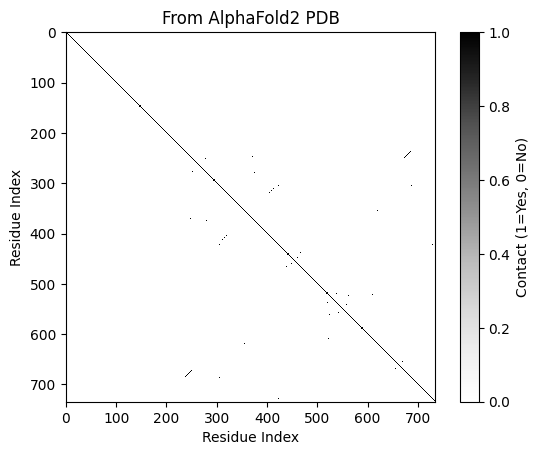

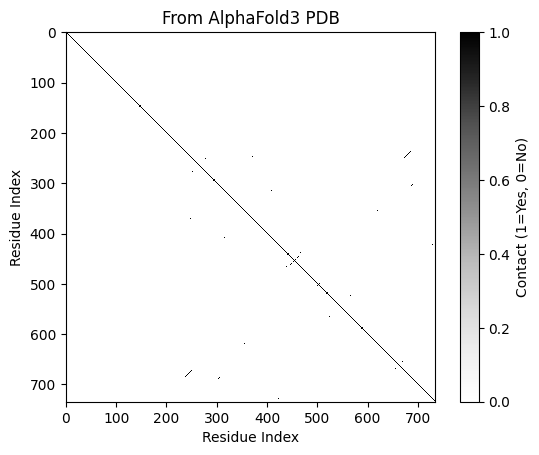

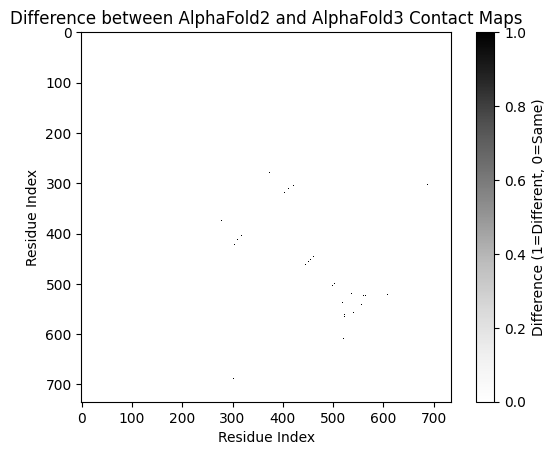

In [18]:
map2 = calculate_contact_map(af2_coords[0], distance_threshold=5.0)
plot_contact_map(map2, "From AlphaFold2 PDB")
map3 = calculate_contact_map(af3_coords[0], distance_threshold=5.0)
plot_contact_map(map3, "From AlphaFold3 PDB")
def compute_contact_map_difference(map1, map2):
    """
    Computes the difference between two contact maps.

    Parameters:
    map1 (2D array): First contact map.
    map2 (2D array): Second contact map.

    Returns:
    2D array: Difference between the two contact maps.
    """
    return np.abs(map1 - map2)
diff_map = compute_contact_map_difference(map2, map3)
plt.imshow(diff_map, cmap='Greys', interpolation='nearest')
plt.title("Difference between AlphaFold2 and AlphaFold3 Contact Maps")
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.colorbar(label='Difference (1=Different, 0=Same)')
plt.show()

Alphafold2 predicts more closely contacted aminoacids than Alphafold3 especially for residues around 400 and higher. Interestingly, that is the region of residues where both models were confident and corresponds to misture of b-sheets and globule structure. That may suggest either higher level of proteins alignment in Alphafold2 or less confident prediction.

#### 2.2 Mutation effect of the surface of the AF3 protein

Look at the model mutation effect predictions (from ESM and PSSM) on surface of your AF3 protein structure. This code outputs a pml file that is run within Pymol.

In [33]:
result

,mutant,mutated_sequence,DMS_score,DMS_score_bin,num_muts,esm_score,pssm_score
0,A572C,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.783106,1,1,-2.819940,0.000000
219,A572D,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-0.932205,1,1,-0.403634,-4.958421
248,A572E,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-3.875080,0,1,-0.462956,-8.417853
265,A572F,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-3.486448,0,1,-0.314972,0.000000
282,A572G,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.166455,1,1,0.050629,-0.656301
...,...,...,...,...,...,...,...
42024,Y576R,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.147604,0,1,0.857737,0.000000
42037,Y576S,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-0.878502,1,1,1.739657,-6.392317
42053,Y576T,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-2.714789,0,1,1.660241,-8.977280
42073,Y576V,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-2.211178,0,1,1.057343,-8.977280


In [48]:
def create_mutability_scores(experiment_single_muts, type):
    """
    Create a dict with mutability scores depends on choice of type, which can be 'PSSM', or 'ESM'.
    PSSM scores, and ESM scores.

    Parameters:
    - experiment_single_muts (pandas.DataFrame): DataFrame containing 'DMS_score', 'PSSM_score', and 'ESM_score'.
    - type (str): Type of mutability score to create. Options are 'PSSM', 'ESM', or 'combined'.

    Returns:
    - dict: A dictionary containing the mutability scores for each mutation in the experiment.
    """
    experiment_single_muts['position'] = experiment_single_muts['mutant'].str[1:-1].astype(int)
    mutability_df = experiment_single_muts.groupby('position')[type].mean()
    mutability_df = (mutability_df - mutability_df.min()) / (mutability_df.max() - mutability_df.min())
    
    return mutability_df.to_dict()

In [56]:
def export_mutability_to_pymol(mutability_scores, pdb_file, output_file="mutability_scores.pml"):
    """
    Exports mutability scores to a PyMOL script that can color the structure by mutability.

    Parameters:
    mutability_scores (dict): Dictionary of residue positions and their mutability scores.
    pdb_file (str): Path to the PDB file of the protein structure locally (to load into pymol).
    output_file (str): Path to the PyMOL script file (default is "mutability_scores.pml").
    """
    with open(output_file, 'w') as f:
        # f.write(f"load {pdb_file}\n")
        f.write(f"color grey\n")

        for residue_index, mutability_score in mutability_scores.items():
            # Generate PyMOL coloring commands based on mutability scores
            color_value = mutability_score  # Scale these scores as needed
            f.write(f"set_color res_{residue_index}_color, [{color_value}, {1 - color_value}, 0]\n")
            f.write(f"color res_{residue_index}_color, resi {residue_index}\n")

        f.write("show cartoon\n")
        f.write("bg_color white\n")
        f.write("set cartoon_transparency, 0.3\n")
        f.write("zoom\n")

    print(f"PyMOL script saved to {output_file}. Run the script in PyMOL to visualize mutability.")


###COMPLETE HERE
#Your mutability scores are a dict of your position-averaged PSSM or ESM scores
#you should scale your mutability scores to be between 0 and 1
#from experiment_single_muts for each position as the key
mut_scores = create_mutability_scores(result, 'DMS_score')
pdb_path = Path.cwd() / "models/alphafold/alphafold3/fold_2025_08_13_22_11_model_4.pdb"
export_mutability_to_pymol(mut_scores, pdb_path, output_file=Path.cwd() / "models/mutability_scores_dms.pml")

PyMOL script saved to /mnt/c/Users/aubog/Documents/Python/Computation_biology/ml_comp_biology/models/mutability_scores_dms.pml. Run the script in PyMOL to visualize mutability.


/tmp/ipykernel_1088/701356128.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_single_muts['position'] = experiment_single_muts['mutant'].str[1:-1].astype(int)


Looking at the protein, what can you say about where it is more mutable? What information does this tell you that is different than looking how mutability changes across the primary sequence?

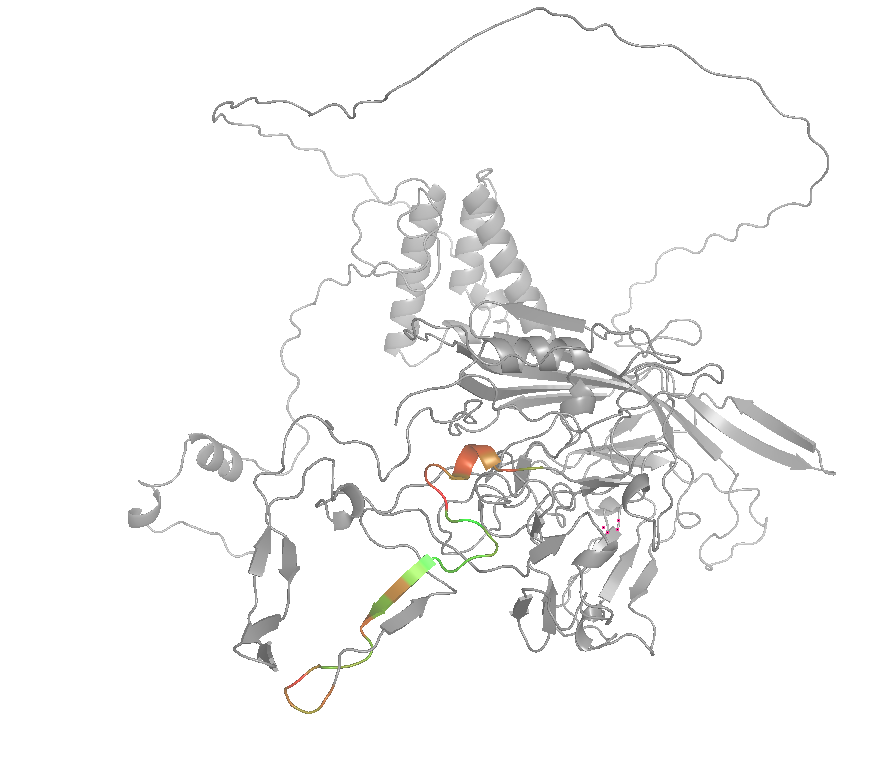

In [57]:
display_image(Path.cwd() / "models/alphafold/pssm.png")
display_image(Path.cwd() / "models/alphafold/esm.png")
display_image(Path.cwd() / "models/alphafold/dsm.png")

Results from DMS more correlates with EMS results than PSSM. In PSSM experiment the most of mutated amino-acids concentrated closely to the $\beta$-sheet. While in the ESM experiment they spreaded in two places, on the outer surface as well as the deep inside. The model experiment (DMS) at the same time show most of the mutated atoms on the outer service of the molecule.